In [1]:
using Distributions
using StatsBase
using PyPlot
using Mamba

# アヒル本4章のデータ
x=Real[ 24, 24, 26, 32, 33, 35, 38, 40, 40, 43, 43, 44, 48, 52,  56,  56,  57,  58,  59,  59]
y=Real[472,403,454,575,546,781,750,601,814,792,745,837,868,988,1092,1007,1233,1202,1123,1314]

20-element Array{Real,1}:
  472
  403
  454
  575
  546
  781
  750
  601
  814
  792
  745
  837
  868
  988
 1092
 1007
 1233
 1202
 1123
 1314

In [2]:
# Model Definition
model = Model(
    y = Stochastic(1,
        (a, b, x, sigma) -> MvNormal(a + b*x, sigma),
        false
    ),
    b = Stochastic(() -> Normal(0, 1000)),
    a = Stochastic(() -> Normal(0, 1000)),
    sigma = Stochastic(() -> Uniform(0, 1e6))
)

Object of type "Mamba.Model"
-------------------------------------------------------------------------------
a:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
b:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
sigma:
A monitored node of type "Mamba.ScalarStochastic"
NaN


In [4]:
# Data Conversion
Dat = Dict{Symbol, Any}(
    :x => x,
    :y => y
)

# Initial Values
inits = [
  Dict{Symbol, Any}(
    :y => y,
    :a => rand(Normal(0, 1)),
    :b => rand(Normal(0, 1)),
    :sigma => rand(Uniform(10,15))
  ) for i in 1:2
]

2-element Array{Dict{Symbol,Any},1}:
 Dict{Symbol,Any}(Pair{Symbol,Any}(:a, 0.63375),Pair{Symbol,Any}(:b, 1.02365),Pair{Symbol,Any}(:y, Real[472, 403, 454, 575, 546, 781, 750, 601, 814, 792, 745, 837, 868, 988, 1092, 1007, 1233, 1202, 1123, 1314]),Pair{Symbol,Any}(:sigma, 12.5888)) 
 Dict{Symbol,Any}(Pair{Symbol,Any}(:a, 0.922685),Pair{Symbol,Any}(:b, 0.33765),Pair{Symbol,Any}(:y, Real[472, 403, 454, 575, 546, 781, 750, 601, 814, 792, 745, 837, 868, 988, 1092, 1007, 1233, 1202, 1123, 1314]),Pair{Symbol,Any}(:sigma, 10.2728))

In [5]:
## Sampling Scheme
scheme = [NUTS([:a,:b,:sigma])]
setsamplers!(model, scheme)

Object of type "Mamba.Model"
-------------------------------------------------------------------------------
a:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
b:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
sigma:
A monitored node of type "Mamba.ScalarStochastic"
NaN


In [7]:
## MCMC Simulations
sim = mcmc(model, Dat, inits, 2000, burnin=1000, thin=1, chains=1)
describe(sim)

MCMC Simulation of 2000 Iterations x 1 Chain...

Chain 1:   1% [0:00:22 of 0:00:22 remaining]
Chain 1:  10% [0:01:01 of 0:01:08 remaining]
Chain 1:  20% [0:00:47 of 0:00:58 remaining]
Chain 1:  30% [0:00:38 of 0:00:55 remaining]
Chain 1:  40% [0:00:32 of 0:00:53 remaining]
Chain 1:  50% [0:00:25 of 0:00:50 remaining]
Chain 1:  60% [0:00:20 of 0:00:50 remaining]
Chain 1:  70% [0:00:15 of 0:00:51 remaining]
Chain 1:  80% [0:00:11 of 0:00:53 remaining]
Chain 1:  90% [0:00:05 of 0:00:54 remaining]
Chain 1: 100% [0:00:00 of 0:00:55 remaining]

Iterations = 1001:2000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

Empirical Posterior Estimates:
          Mean        SD       Naive SE     MCSE       ESS   
sigma   84.498765 15.5085775 0.490424280 0.68927615 506.24112
    b   21.955192  1.6355915 0.051721944 0.17563254  86.72408
    a -120.771614 72.9060900 2.305492998 7.94019602  84.30730

Quantiles:
          2.5%       25.0%       50.0%       75.0%      97.5%  
sigma   61.136069 

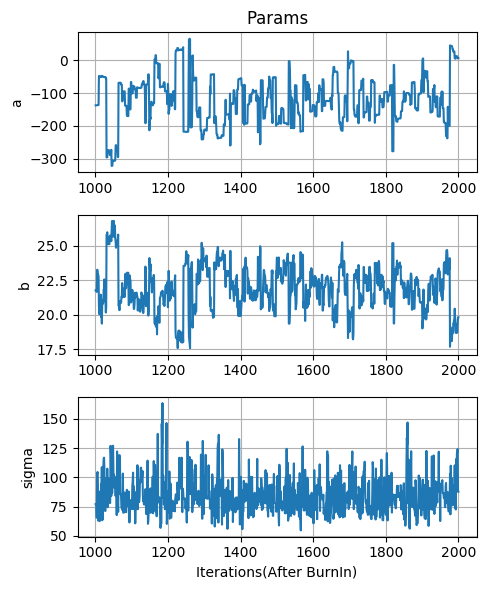

In [8]:
# Plot 
iterations=1001:2000

fig = figure(figsize=(5,6))
ax = fig[:add_subplot](3,1,1)
PyPlot.plot(iterations,sim.value[:,3,1])
ylabel("a")
title("Params")
grid("on")

ax = fig[:add_subplot](3,1,2)
PyPlot.plot(iterations,sim.value[:,2,1])
ylabel("b")
grid("on")

ax = fig[:add_subplot](3,1,3)
PyPlot.plot(iterations,sim.value[:,1,1])
xlabel("Iterations(After BurnIn)")
ylabel("sigma")
grid("on")

tight_layout()

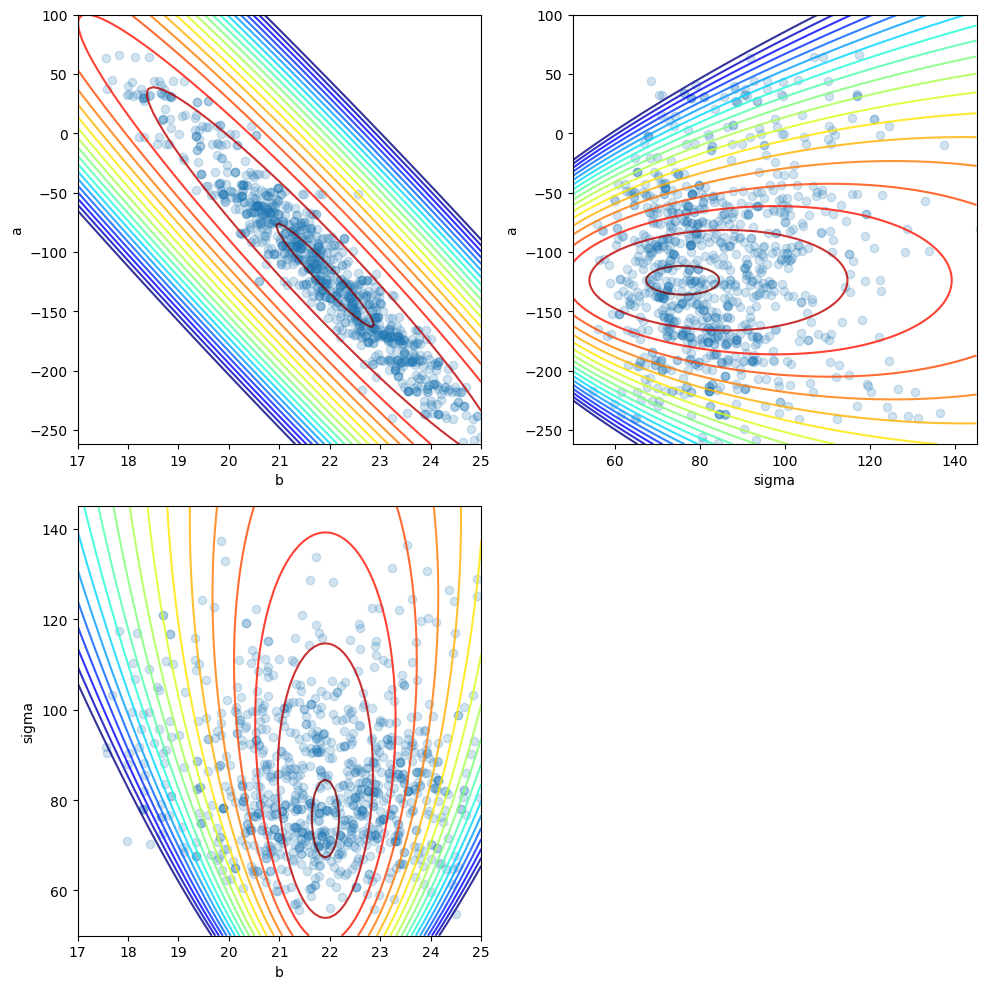

In [9]:
function likelihood(a, b, sigma)
    y_pred = a + b*x
    likelihoods = [logpdf(Normal(aa, sigma), bb) for (aa,bb) in zip(y_pred,y)]
    l_sum = sum(likelihoods)
    return l_sum
end

_a = -120.0
_b = 22.0
_sigma = 79.0

a_list = collect(-262:100)
b_list = collect(17:0.1:25)
sigma_list = collect(50:145)

ab_list = [likelihood(tmp_a,tmp_b,_sigma) for tmp_a in a_list, tmp_b in b_list]
ac_list = [likelihood(tmp_a,_b,    tmp_sigma) for tmp_a in a_list, tmp_sigma in sigma_list]
cb_list = [likelihood(_a, tmp_b,tmp_sigma) for tmp_sigma in sigma_list, tmp_b in b_list]

levels = collect(-160:2.5:-115)

# 結果の取り出し
a = sim.value[:,3,1]
b = sim.value[:,2,1]
sigma = sim.value[:,1,1]

# Plot 
fig = figure(figsize=(10,10))
ax = fig[:add_subplot](2,2,1)

b_grid = repmat(b_list',length(a_list),1)
a_grid = repmat(a_list, 1, length(b_list))

cp = ax[:contour](b_grid,a_grid, ab_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(b,a,alpha=0.2)
xlabel("b")
ylabel("a")
ax[:set_xlim]([b_list[1],b_list[end]])
ax[:set_ylim]([a_list[1],a_list[end]])

subplot(222)
ax = fig[:add_subplot](2,2,2)

c_grid = repmat(sigma_list',length(a_list),1)
a_grid = repmat(a_list, 1, length(sigma_list))

cp = ax[:contour](c_grid,a_grid, ac_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(sigma,a,alpha=0.2)
xlabel("sigma")
ylabel("a")
ax[:set_xlim]([sigma_list[1],sigma_list[end]])
ax[:set_ylim]([a_list[1],a_list[end]])

subplot(223)
ax = fig[:add_subplot](2,2,3)

b_grid = repmat(b_list',length(sigma_list),1)
c_grid = repmat(sigma_list, 1, length(b_list))

cp = ax[:contour](b_grid,c_grid, cb_list, levels=levels, linewidth=2.0, cmap="jet",alpha=0.8)
scatter(b,sigma,alpha=0.2)
xlabel("b")
ylabel("sigma")
ax[:set_xlim]([b_list[1],b_list[end]])
ax[:set_ylim]([sigma_list[1],sigma_list[end]])
tight_layout()

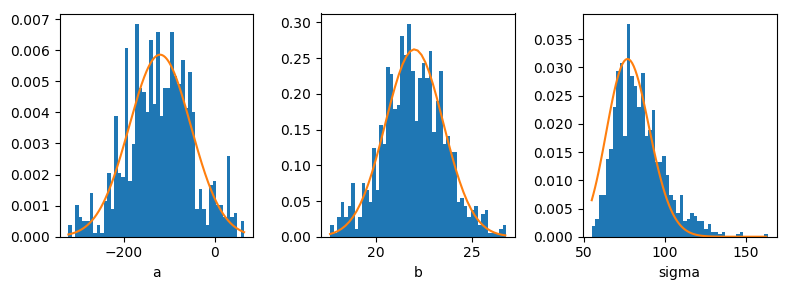

In [10]:
fig = figure("pyplot_histogram",figsize=(8,3))

ax = fig[:add_subplot](1,3,1)
h = plt[:hist](a,50, normed=true)
plottyx = collect(minimum(a):maximum(a))
PyPlot.plot(plottyx, pdf.(Normal(_a,68.15),plottyx))
xlabel("a")

ax = fig[:add_subplot](1,3,2)
h = plt[:hist](b,50, normed=true)
plottyx = collect(minimum(b):0.2:maximum(b))
PyPlot.plot(plottyx, pdf.(Normal(_b,1.52),plottyx))
xlabel("b")

ax = fig[:add_subplot](1,3,3)
h = plt[:hist](sigma,50, normed=true)
plottyx = collect(minimum(sigma):maximum(sigma))
PyPlot.plot(plottyx, pdf.(Chi(18),plottyx/(79.1/sqrt(18)))/18)
xlabel("sigma")

tight_layout()